In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import datetime
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords
import prepare
import wrangle 
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## Initial Planning Analysis

In [2]:
# # read in primary utterances csv for dataframe
# df = pd.read_csv('./utterances.csv')
# df.head()

In [3]:
# # find utterance count per episode
# df.episode.value_counts()

In [4]:
# # find utterance count per episode
# test = df.episode.value_counts() < 2
# test.sum()

In [5]:
# # pull in episodes df
# ep_df = pd.read_csv('./episodes.csv')
# ep_df.head()

In [6]:
# # check episode content to see if it matches episode id
# df[df.episode == 92554].utterance.to_list()

In [7]:
# # check ep_df.id = df.episode
# ep_df[ep_df.id == 92554].title.to_list()

### Initial takeaways
There are episodes with one utterance, showing less interview setting and more reporting.

ep_df.id == df.episode

### Acquire


In [8]:
# df = pd.read_csv('./utterances.csv')
# ep_df = pd.read_csv('./episodes.csv')


In [9]:
# df['speaker'] = df.speaker.str.lower()
# df['program'] = df.program.str.lower()
# df['title'] = df.title.str.lower()

In [10]:
# # joining utterances df ('df') and episodes on 'id'
# joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
# joined_df.drop(columns = ['id'], inplace=True)
# joined_df.rename(columns={'episode':'episode_id'}, inplace = True)

In [11]:
# joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')

In [12]:
# df = acquire.get_df()

In [13]:
# df['speaker'] = df.speaker.str.replace(r'\([^)]*\)','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'host','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'[^a-z0-9\s\.]','', regex=True).str.strip()
# df['speaker'] = df.speaker.str.replace('lourdes','lulu')

In [14]:
# host_map = pd.read_json('host-map.json')
# host_map = host_map.T
# hosts = host_map.name.to_list()
# hosts.append('neal conan')

In [15]:
# df['is_host'] = df.speaker.isin(hosts)

In [16]:
# df

## Preparation

- nulls
- duplicates
- create sentiment score
- use prep functions
- keep some punctuation
- split
- date to datetime

In [17]:

# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()
# # create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']
# # drop duplicates
# df.drop_duplicates(inplace = True)
# # drop nulls
# df.dropna(inplace=True)
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)
# # vader sentiment analysis
# sia = nltk.sentiment.SentimentIntensityAnalyzer()
# df['vader'] = df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# # date column to datetime
# df['date'] = pd.to_datetime(df.episode_date)
# # cutoff dates prior to 2005 due to low observation count
# df = df[df.date > '2005']
# # double check drop nulls
# df.dropna(inplace = True)

In [18]:
# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()


In [19]:
# create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]

In [20]:
# # drop nulls
# df.dropna(inplace=True)

In [21]:
# drop duplicates
# df.drop_duplicates(inplace = True)

In [22]:
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']

In [23]:
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']


In [24]:
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]


In [25]:
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)


In [26]:
# df.head()

In [27]:
# df = wrangle.get_npr_data()

## JOSH
- Are there words that are said more frequently by hosts? By time of day? By category?
What host(s) say(s) the most words?

In [2]:
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [30]:
# df['lemmatized'] = df.lemmatized.astype(str)
# df['clean'] = df.clean.astype(str)

In [4]:
df = df.astype({'clean':str,'lemmatized':str})

In [5]:
df['message_length'] = df.clean.apply(len)
df['word_count'] = df.clean.apply(str.split).apply(len)

In [6]:
train, validate, test = wrangle.split_data(df)

### Hosts

In [7]:
# df of hosts
host_df = df[df.is_host==True]
# hosts with most interviews
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

In [8]:
# aggregate utterances by the speakers that are in top 10 hosts
host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['clean'].agg(lambda col: ' '.join(col))

In [9]:
def string_cleaning(s):
    '''
    Function to remove punctuation and numbers from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z'\s]", '', s)

    return s

In [10]:
more_stopwords = pd.read_excel('stop_words_df.xlsx')
more_stopwords = more_stopwords.words.to_list()

In [11]:
host_words = host_words.apply(string_cleaning).apply(remove_stopwords, extra_words = more_stopwords)

In [12]:
# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan'].split()).value_counts()

In [13]:
# create word counts dataframe of all host word frequencies
word_counts = pd.concat([conan_freq, flatow_freq, inskeep_freq, siegel_freq, block_freq, montagne_freq, chideya_freq, simon_freq, martin_freq, greene_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['conan', 'flatow', 'inskeep', 'siegel', 'block', 'montagne', 'chideya', 'simon', 'martin', 'greene']
word_counts

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
talk,18268,3861,934,553,807,451,997,420,536,589
let,13896,3366,1617,623,619,545,1542,682,754,979
nation,13481,855,264,201,144,210,157,138,60,146
today,10582,1308,1530,2447,1779,1137,916,516,649,785
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
...,...,...,...,...,...,...,...,...,...,...
secor,0,0,0,0,0,0,0,0,0,1
pallai,0,0,0,0,0,0,0,0,0,1
irkutsk,0,0,0,0,0,0,0,0,0,1
avla,0,0,0,0,0,0,0,0,0,1


In [14]:
# create dictionary for word clouds
word_lists = {'conan':host_words['neal conan'], 
'flatow':host_words['ira flatow'], 
'inskeep': host_words['steve inskeep'], 
'siegel':host_words['robert siegel'], 
'block':host_words['melissa block'], 
'montagne':host_words['renee montagne'], 
'chideya':host_words['farai chideya'], 
'simon':host_words['scott simon'], 
'martin':host_words['rachel martin'], 
'greene':host_words['david greene']}

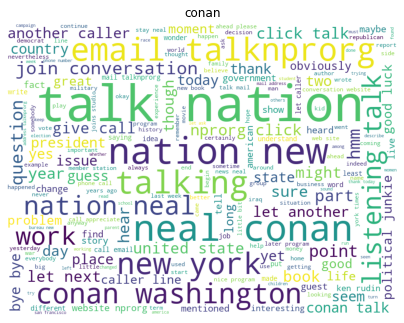

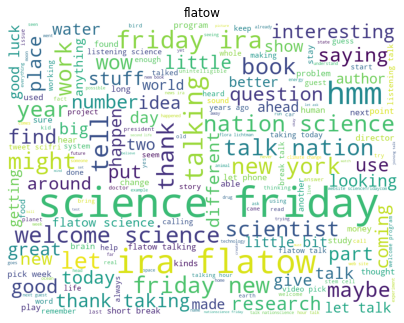

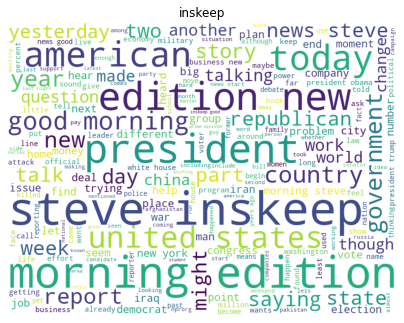

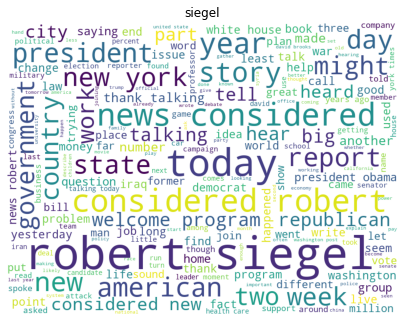

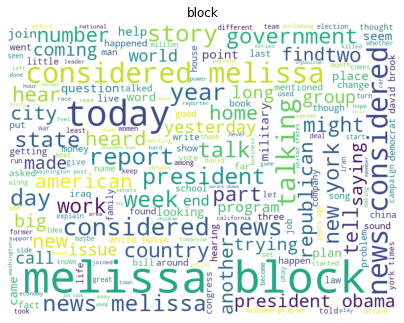

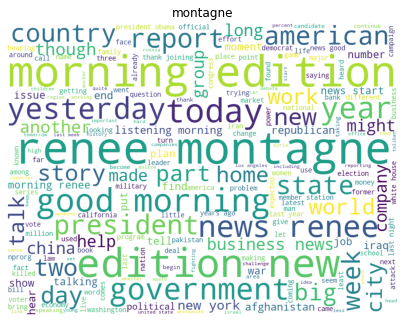

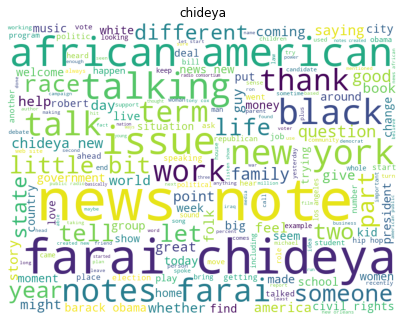

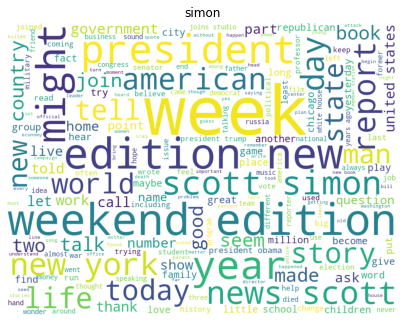

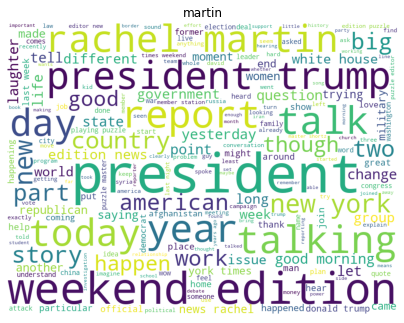

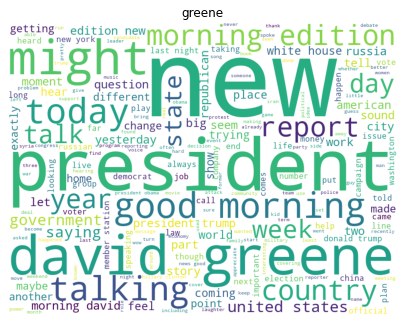

In [15]:
# word clouds
for h in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

In [16]:
# find mean character count of each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').message_length.mean())
# find mean word count of each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.mean())
# find total word count for each speaker's corpus
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.sum())

speaker
david greene      180.641208
farai chideya     190.247265
ira flatow        122.812125
melissa block     164.804195
neal conan        148.897502
rachel martin     159.288261
renee montagne    170.935861
robert siegel     174.663300
scott simon       181.436066
steve inskeep     169.304454
Name: message_length, dtype: float64
speaker
david greene      35.210716
farai chideya     37.711181
ira flatow        25.501025
melissa block     31.929640
neal conan        30.021321
rachel martin     31.105428
renee montagne    32.481760
robert siegel     33.539500
scott simon       35.171162
steve inskeep     32.483828
Name: word_count, dtype: float64
speaker
david greene       594709
farai chideya      768667
ira flatow        1044879
melissa block      717012
neal conan        4293259
rachel martin      546118
renee montagne     677602
robert siegel      936557
scott simon        663715
steve inskeep     1081679
Name: word_count, dtype: int64


In [17]:
# each speaker's character count by story
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).message_length.sum()

speaker        story_id_num
david greene   777             1742
               780              189
               800              667
               802              708
               804              489
                               ... 
steve inskeep  133180            18
               133182            23
               133184           453
               135547           365
               138265          1624
Name: message_length, Length: 57101, dtype: int64

In [18]:
# find each speaker's word count per story
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).word_count.sum()

speaker        story_id_num
david greene   777             335
               780              38
               800             121
               802             141
               804              91
                              ... 
steve inskeep  133180            5
               133182            6
               133184           80
               135547           69
               138265          311
Name: word_count, Length: 57101, dtype: int64

In [19]:
# train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).word_count.mean()

## Are there words that are said more frequently by each host?

In [20]:
# create empty dicitonary
top_words_by_host = {}

# populate dictionary with dataframes of each hosts' top 20 words compared to other hosts
for host in word_counts.columns.to_list():
    top_words_by_host[host] = pd.DataFrame(word_counts.sort_values(host, ascending = False).head(20))

In [21]:
top_words_by_host['conan']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
talk,18268,3861,934,553,807,451,997,420,536,589
let,13896,3366,1617,623,619,545,1542,682,754,979
nation,13481,855,264,201,144,210,157,138,60,146
today,10582,1308,1530,2447,1779,1137,916,516,649,785
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
call,9730,625,286,234,190,161,223,272,216,170
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
also,8849,1886,1518,1072,850,931,1600,646,589,860
email,7412,50,43,36,35,23,16,27,24,25
talking,6878,2617,726,1373,823,359,844,244,520,703


In [22]:
top_words_by_host['flatow']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
science,867,5339,154,142,84,107,86,83,71,124
talk,18268,3861,934,553,807,451,997,420,536,589
friday,494,3667,110,136,101,60,81,105,76,60
let,13896,3366,1617,623,619,545,1542,682,754,979
talking,6878,2617,726,1373,823,359,844,244,520,703
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
hmm,4343,2430,76,94,83,11,52,104,15,17
ira,227,2194,1,10,7,6,3,2,3,3
flatow,159,2120,0,2,0,0,1,0,0,0
thank,4104,1912,167,942,251,541,999,419,323,243


In [23]:
top_words_by_host['inskeep']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,622,50,3756,217,198,2953,51,196,878,1842
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
steve,885,189,2113,99,68,280,21,71,135,216
inskeep,25,0,2037,4,8,105,0,4,26,51
reports,395,42,1955,1539,1306,1869,82,636,373,657
edition,376,17,1945,35,53,1658,12,842,733,681
good,5174,1677,1688,590,432,1216,545,484,802,1084
let,13896,3366,1617,623,619,545,1542,682,754,979


In [24]:
top_words_by_host['siegel']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
robert,1111,163,168,2858,232,130,435,118,108,87
siegel,49,6,1,2660,30,0,1,6,5,3
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
today,10582,1308,1530,2447,1779,1137,916,516,649,785
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
considered,502,28,172,1878,1751,92,83,132,67,79
reports,395,42,1955,1539,1306,1869,82,636,373,657
year,3400,729,1260,1430,899,1011,582,786,601,770
talking,6878,2617,726,1373,823,359,844,244,520,703


In [25]:
top_words_by_host['block']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
block,102,34,55,85,2538,26,34,25,19,28
melissa,127,6,5,68,2528,4,86,13,19,31
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
today,10582,1308,1530,2447,1779,1137,916,516,649,785
considered,502,28,172,1878,1751,92,83,132,67,79
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
reports,395,42,1955,1539,1306,1869,82,636,373,657
year,3400,729,1260,1430,899,1011,582,786,601,770
last,3869,548,1402,1005,862,1163,677,715,737,825


In [26]:
top_words_by_host['montagne']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,622,50,3756,217,198,2953,51,196,878,1842
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
reports,395,42,1955,1539,1306,1869,82,636,373,657
renee,56,2,163,2,2,1763,7,6,4,55
montagne,2,0,79,1,0,1747,0,1,1,27
edition,376,17,1945,35,53,1658,12,842,733,681
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
good,5174,1677,1688,590,432,1216,545,484,802,1084
last,3869,548,1402,1005,862,1163,677,715,737,825


In [27]:
top_words_by_host['chideya']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
black,846,74,250,182,134,190,2057,132,129,120
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
notes,120,22,28,21,21,14,1659,25,14,4
also,8849,1886,1518,1072,850,931,1600,646,589,860
let,13896,3366,1617,623,619,545,1542,682,754,979
african,575,15,176,98,99,126,1302,94,52,68
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
farai,3,0,0,0,0,0,1084,0,0,2
american,2804,332,1067,765,407,569,1072,463,340,332


In [28]:
top_words_by_host['simon']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
week,3004,1029,1100,1057,787,837,537,1395,907,623
weekend,460,281,319,172,183,206,103,984,760,237
years,4400,1040,1482,1238,839,1004,663,917,625,682
joins,3672,563,145,589,368,208,86,874,445,193
edition,376,17,1945,35,53,1658,12,842,733,681
scott,591,105,388,237,219,166,46,790,277,230
year,3400,729,1260,1430,899,1011,582,786,601,770


In [29]:
top_words_by_host['martin']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
trump,22,1,1012,546,50,156,11,483,1039,1047
puzzle,170,13,0,11,39,22,3,4,931,33
week,3004,1029,1100,1057,787,837,537,1395,907,623
morning,622,50,3756,217,198,2953,51,196,878,1842
good,5174,1677,1688,590,432,1216,545,484,802,1084
weekend,460,281,319,172,183,206,103,984,760,237
let,13896,3366,1617,623,619,545,1542,682,754,979
last,3869,548,1402,1005,862,1163,677,715,737,825


In [30]:
top_words_by_host['greene']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
morning,622,50,3756,217,198,2953,51,196,878,1842
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
good,5174,1677,1688,590,432,1216,545,484,802,1084
david,2546,359,678,869,766,436,121,289,291,1051
trump,22,1,1012,546,50,156,11,483,1039,1047
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
let,13896,3366,1617,623,619,545,1542,682,754,979
could,3451,1594,1205,903,678,750,604,744,554,926
also,8849,1886,1518,1072,850,931,1600,646,589,860


### Are there words more frequently said by hosts vs guests?

due to length I will not run this yet

In [109]:
# guest_df = pd.DataFrame(train[~train.speaker.isin(hosts_with_the_most)].groupby('is_host')['clean'].agg(lambda col: ' '.join(col))).T

In [121]:
# guest_words = guest_df[0]

In [117]:
# guest_words = train[~train.speaker.isin(hosts_with_the_most)].groupby('is_host')['clean'].agg(lambda col: ' '.join(col)).T
# guest_freq = pd.Series(guest_words).value_counts()
# 

## Model

In [54]:
from sklearn.metrics import classification_report, accuracy_score


The data is large and has to be sampled.

In [38]:
df2 = df.sample(10_000, random_state = 222)

train, validate, test = wrangle.split_data(df2)

Check df shapes

In [39]:
print(train.shape)
print(validate.shape)
print(test.shape)

(5600, 13)
(2400, 13)
(2000, 13)


### Creating TF-IDF, X and y

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define utterances
utterances = [utterance for utterance in train.lemmatized]

# create tfidf object
tfidf = TfidfVectorizer()

# fit/use tfidf
#train
tfidfs = tfidf.fit_transform(utterances)

#validate
validate_tfidf = tfidf.transform([utterance for utterance in validate.lemmatized])

#test
test_tfidf = tfidf.transform([utterance for utterance in test.lemmatized])

In [51]:
# drop columns not needed for modeling
features = train.drop(columns = ['story_id_num','utterance_order','speaker','utterance','program','title','is_host','clean','lemmatized','date']).columns.to_list()

In [52]:
# Create X and y for train, validate, test
X_train = train[features]
y_train = train.is_host

X_validate = validate[features]
y_validate = validate.is_host

X_test = test[features]
y_test = test.is_host

### Baseline

Nobody's a host!

In [78]:
# create baseline on mode (is_host == False)
train['baseline_pred'] = False
validate['baseline_pred'] = False
test['baseline_pred'] = False

print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.baseline_pred)))
print('---')
print(classification_report(train.is_host, train.baseline_pred))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.baseline_pred)))
print('---')
print(classification_report(validate.is_host, validate.baseline_pred))

Train Accuracy: 61.61%
---
              precision    recall  f1-score   support

       False       0.62      1.00      0.76      3450
        True       0.00      0.00      0.00      2150

    accuracy                           0.62      5600
   macro avg       0.31      0.50      0.38      5600
weighted avg       0.38      0.62      0.47      5600

Validate Accuracy: 62.83%
---
              precision    recall  f1-score   support

       False       0.63      1.00      0.77      1508
        True       0.00      0.00      0.00       892

    accuracy                           0.63      2400
   macro avg       0.31      0.50      0.39      2400
weighted avg       0.39      0.63      0.48      2400



### Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)
clf = clf.fit(X_train, y_train)
train['predicted_clf'] = clf.predict(X_train)

validate['predicted_clf'] = clf.predict(X_validate)

In [107]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.predicted_clf)))
print('---')
print(classification_report(train.is_host, train.predicted_clf))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.predicted_clf)))
print('---')
print(classification_report(validate.is_host, validate.predicted_clf))

Train Accuracy: 64.68%
---
              precision    recall  f1-score   support

       False       0.66      0.86      0.75      3450
        True       0.58      0.30      0.40      2150

    accuracy                           0.65      5600
   macro avg       0.62      0.58      0.57      5600
weighted avg       0.63      0.65      0.61      5600

Validate Accuracy: 65.00%
---
              precision    recall  f1-score   support

       False       0.68      0.85      0.75      1508
        True       0.55      0.31      0.39       892

    accuracy                           0.65      2400
   macro avg       0.61      0.58      0.57      2400
weighted avg       0.63      0.65      0.62      2400



### Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_leaf=5,criterion='gini',max_depth=10,random_state=222)

rf.fit(X_train, y_train)
train['predicted_rf'] = rf.predict(X_train)

validate['predicted_rf'] = rf.predict(X_validate)

In [121]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.predicted_rf)))
print('---')
print(classification_report(train.is_host, train.predicted_rf))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.predicted_rf)))
print('---')
print(classification_report(validate.is_host, validate.predicted_rf))

Train Accuracy: 69.54%
---
              precision    recall  f1-score   support

       False       0.70      0.89      0.78      3450
        True       0.68      0.39      0.49      2150

    accuracy                           0.70      5600
   macro avg       0.69      0.64      0.64      5600
weighted avg       0.69      0.70      0.67      5600

Validate Accuracy: 65.42%
---
              precision    recall  f1-score   support

       False       0.68      0.85      0.75      1508
        True       0.56      0.33      0.41       892

    accuracy                           0.65      2400
   macro avg       0.62      0.59      0.58      2400
weighted avg       0.64      0.65      0.63      2400

